In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.append("../src")

# Add autoreload magic command
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import pandas as pd
from IPython.display import display

# from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from model_selection import modelSelection

warnings.simplefilter(action="ignore", category=FutureWarning)


RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

df = pd.read_csv(PATH, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]

# Split DBTL cycles
df_A = df.loc[DBTL_A]
df_B = df.loc[DBTL_B]

df_A.sort_values(by=RESPONSE_VARS, ascending=False, inplace=True)
df_B.sort_values(by=RESPONSE_VARS, ascending=False, inplace=True)

print(f"Shape of DBTL cycle 1: {df_A.shape} and DBTL cycle 2: {df_B.shape}")

# Define train and test sets
X_train = df_A[INPUT_VARS]
y_train = df_A[RESPONSE_VARS].values.ravel()

X_test = df_B[INPUT_VARS]
y_test = df_B[RESPONSE_VARS].values.ravel()


# Calculate bounds of pathway proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float = 0.10):
    bounds = pd.DataFrame(index=["min", "max"], columns=input_vars)
    X = df[input_vars]
    max_values = X.max()
    min_values = X.min()
    delta = max_values - min_values
    lb = (min_values - epsilon * delta).clip(lower=min_values)
    ub = max_values + epsilon * delta
    bounds.loc["min"] = lb
    bounds.loc["max"] = ub
    return bounds


bounds = get_bounds(df_A, INPUT_VARS)
display(bounds)

Shape of DBTL cycle 1: (27, 10) and DBTL cycle 2: (3, 10)


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0219,0.1899,0.7143,0.0983,0.4215,1.2332,0.0605,0.028,0.0429
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


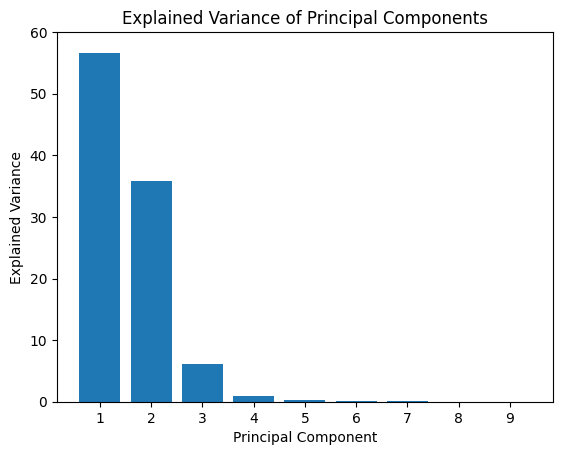

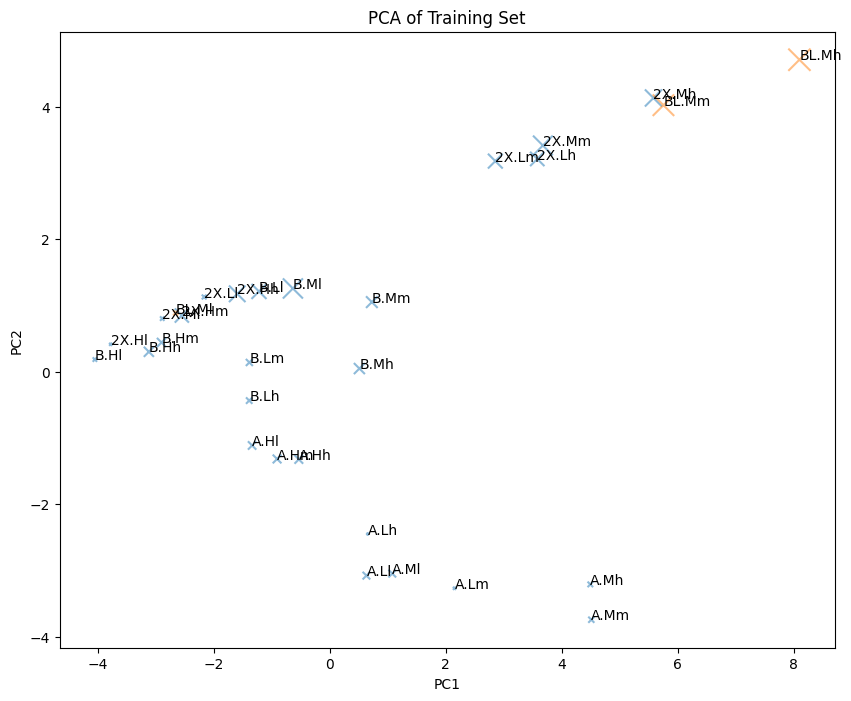

In [2]:
# Perform PCA on the training set
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Get percentage of variance explained by each component
explained_variance = pca.explained_variance_ratio_

plt.bar(range(1, pca.n_components_+1), 100 * explained_variance)
plt.xticks(range(1, pca.n_components_+1))
plt.ylim(0, 60)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("Explained Variance of Principal Components")
plt.show()

# Plot PC1 vs PC2; Label points based on index;
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], s=df_A[RESPONSE_VARS].values.ravel() * 2, alpha=0.5, marker='x')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], s=df_B[RESPONSE_VARS].values.ravel() * 2, alpha=0.5, marker='x')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Training Set")
for i, txt in enumerate(df_A.index):
    plt.annotate(txt, (X_train_pca[i, 0], X_train_pca[i, 1]), fontsize=10)
for i, txt in enumerate(df_B.index):
    plt.annotate(txt, (X_test_pca[i, 0], X_test_pca[i, 1]), fontsize=10)
plt.show()


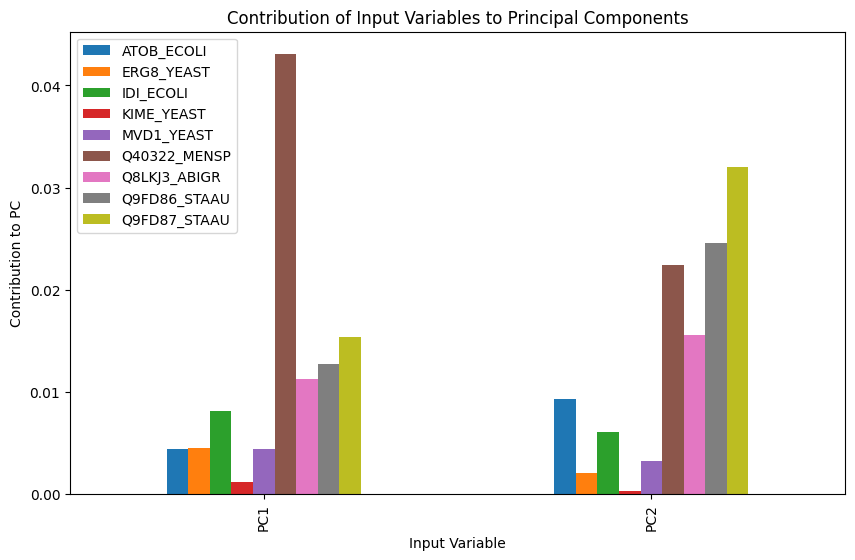

In [3]:
import numpy as np

# Assuming you have already performed PCA and have the PCA object named 'pca'
# Get the loadings of the first PC
loadings = pca.components_


# Calculate the contribution of each input to the first PC
contribution = np.abs(loadings) / np.sum(np.abs(loadings))

contribution_df = pd.DataFrame(contribution, columns=INPUT_VARS)    
contribution_df.index = [f"PC{i+1}" for i in range(pca.n_components_)]
contribution_df = contribution_df.loc[['PC1','PC2']]

# Bar plot of the contribution of each input to the first PC
contribution_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Input Variable')
plt.ylabel('Contribution to PC')
plt.title('Contribution of Input Variables to Principal Components')
plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Tune and train an XGBoost model using RandomizedSearchCV
param_grid = {
    "n_estimators": [5, 8, 10, 12, 15, 20, 25, 28, 32, 40, 50, 100, 200, 300],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3, 0.4],
    "reg_alpha": [0, 0.1, 0.2, 0.3, 0.4],
    "reg_lambda": [0, 0.1, 0.2, 0.3, 0.4],
}


xgb_model = XGBRegressor(objective="reg:squarederror")
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

random_search.fit(X_train, y_train)

# Get the best model
best_xgb = random_search.best_estimator_

# Cross-validated performance of the best model
cv_score = -random_search.best_score_
print(f"Cross-validated RMSE: {cv_score:.4f}")

results = pd.DataFrame()
results["Actual"] = y_train
results["Predicted"] = random_search.predict(X_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


Cross-validated RMSE: 722.0109


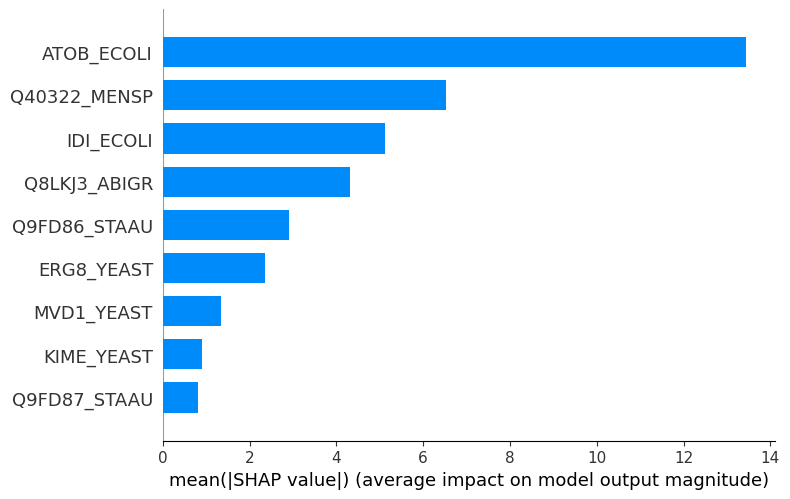

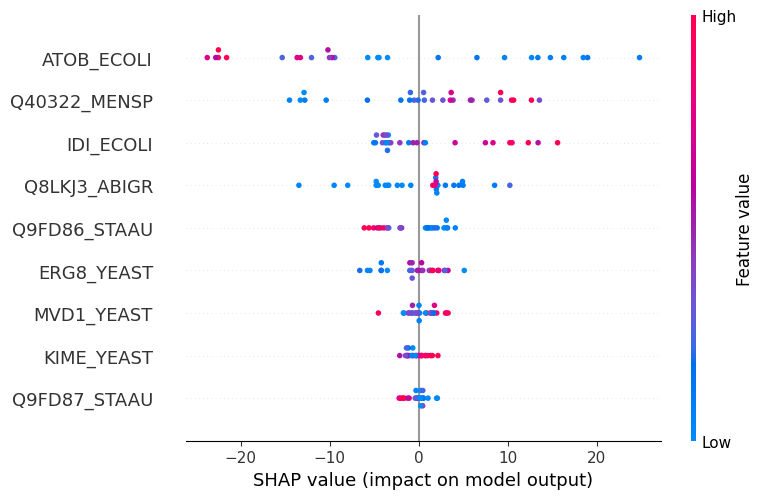

In [5]:
# Calculate SHAP values for the best model
import shap

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_train, feature_names=INPUT_VARS, plot_type='bar')

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_train, feature_names=INPUT_VARS)

Model evaluation (Bootstrap)

In [28]:
def bootstrap(X, y, model: object, n: int = 100):
    mse_values = []
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
        mse_values.append(mean_squared_error(y_test, y_pred))
    return mae_values, mse_values

mae_values, mse_values = bootstrap(X_train, y_train, best_xgb)
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")
print(f"Bootstraped Mean(MSE) = {np.mean(mse_values)}")

print(f"Bootstraped std(MAE) = {np.std(mae_values)}")
print(f"Bootstraped std(MSE) = {np.std(mse_values)}")

best_xgb.fit(X_train, y_train)

  1%|          | 1/100 [00:00<00:22,  4.42it/s]

100%|██████████| 100/100 [00:10<00:00,  9.40it/s]

Bootstraped Mean(MAE) = 18.72054077379582
Bootstraped Mean(MSE) = 648.0258175195986
Bootstraped std(MAE) = 5.672773656191731
Bootstraped std(MSE) = 416.67324298292954


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Explainable AI 

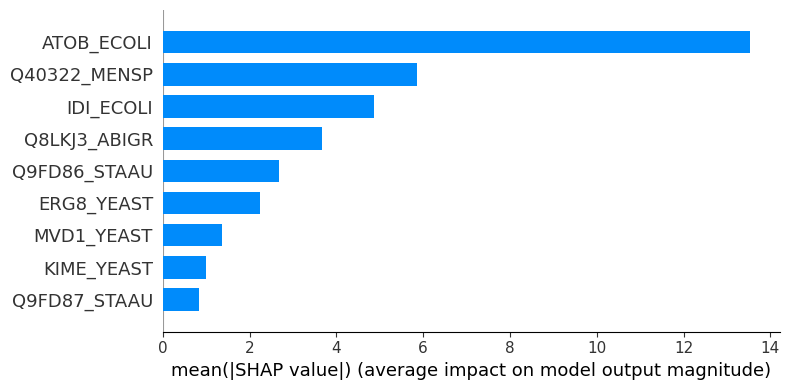

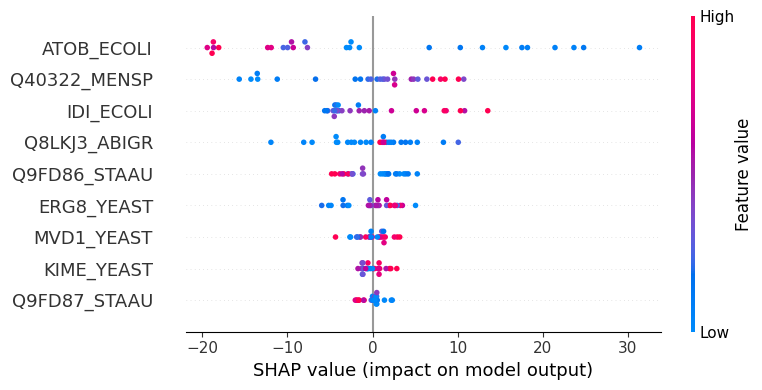

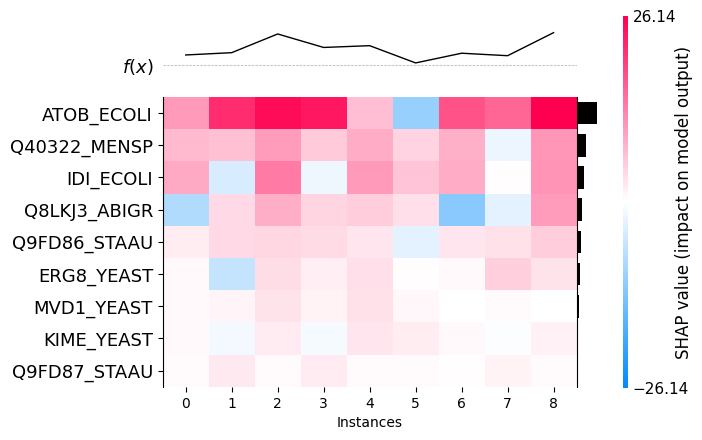

In [29]:
import shap
import matplotlib.pyplot as plt

def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])


shap_explainer = shap.TreeExplainer(best_xgb, df_A[INPUT_VARS])
shap_values = shap_explainer(df_A[INPUT_VARS])
shap_df = pd.DataFrame(shap_values.values, columns=INPUT_VARS)
shap_df["pred"] = best_xgb.predict(df_A[INPUT_VARS])
shap_df["true"] = df_A[RESPONSE_VARS].values.ravel()
shap_df.sort_values(by="pred", ascending=False, inplace=True)
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="bar", plot_size=(8, 4))
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="dot", plot_size=(8, 4))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(0), plot_width=6)

In [30]:
# idx=0
# shap.decision_plot(shap_explainer.expected_value, 
#                    shap_df[INPUT_VARS].iloc[idx].values, 
#                    INPUT_VARS)

# print(shap_df[['pred', 'true']].iloc[idx])

In [31]:
# feature = "KIME_YEAST"
# pdplot(df_A[INPUT_VARS], feature, best_xgb, ice=True)
# shap_scatter(feature)

In [32]:
# shap.force_plot(shap_explainer.expected_value, 
#                    shap_df[INPUT_VARS].iloc[2].values, 
#                    features=INPUT_VARS,
#                    matplotlib=True, show=True)

Lime

In [33]:
# Create synthetic dataset from bounds
# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(1000)
LB = bounds.T["min"].values.tolist()
UB = bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["Limonene"] = best_xgb.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("Limonene", ascending=False, inplace=True)
# Drop rows with Limonene < 0
sample_df = sample_df[sample_df["Limonene"] > 0]
X_synth = sample_df[INPUT_VARS]
y_synth = sample_df["Limonene"]

In [34]:
# import lime
# import lime.lime_tabular

# explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=INPUT_VARS,  
#                                                    verbose=True, mode='regression')
                                                   
# i = 22
# exp = explainer.explain_instance(X_train.values[i], final_model.predict)
# exp.show_in_notebook(show_table=True, show_all=True)
# exp.as_list()
# exp.as_pyplot_figure();

#### Sampling

Create new `sampling bounds`, to generate/recommend new strain designs.

In [16]:
bounds

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0219,0.1899,0.7143,0.0983,0.4215,1.2332,0.0605,0.028,0.0429
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


In [15]:
df_B

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
BL.Mh,1.95983,0.78130,2.59550,1.42496,4.10495,13.59919,1.86762,0.39057,0.65389,127.99494
BL.Mm,1.25540,0.58985,2.29065,1.04860,3.19300,11.31405,1.63235,0.25975,0.41045,119.81367
BL.Ml,0.24012,0.19050,0.94884,0.38070,1.30811,2.72406,0.11237,0.05002,0.08503,6.72018


In [32]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds["Q40322_MENSP"].loc["min"] = 9.58
sampling_bounds["Q40322_MENSP"].loc["max"] = 14

sampling_bounds["IDI_ECOLI"].loc["min"] = 2.0
sampling_bounds["IDI_ECOLI"].loc["max"] = 3.0

sampling_bounds["Q9FD87_STAAU"].loc["min"] = 0.2 
sampling_bounds["Q9FD87_STAAU"].loc["max"] = 0.4 

sampling_bounds["Q8LKJ3_ABIGR"].loc["min"] = 1.27 
sampling_bounds["Q8LKJ3_ABIGR"].loc["max"] = 2.0

sampling_bounds["Q9FD86_STAAU"].loc["min"] = 0.2 
sampling_bounds["Q9FD86_STAAU"].loc["max"] = 0.8 

sampling_bounds["MVD1_YEAST"].loc["min"] = 3.0
sampling_bounds["MVD1_YEAST"].loc["max"] = 4.5

sampling_bounds["ERG8_YEAST"].loc["min"] = 0.5
sampling_bounds["ERG8_YEAST"].loc["max"] = 1.0

sampling_bounds["ATOB_ECOLI"].loc["min"] = 1.0
sampling_bounds["ATOB_ECOLI"].loc["max"] = 2.0

sampling_bounds["KIME_YEAST"].loc["min"] = 1.0
sampling_bounds["KIME_YEAST"].loc["max"] = 2.0


# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(100000)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = best_xgb.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)

In [33]:
sample_df

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,pred
72057,1.715366,0.950406,2.981146,1.885225,3.399813,10.258845,1.501703,0.335066,0.284431,46.209145
34259,1.876212,0.944077,2.853572,1.757218,3.301712,12.325046,1.524914,0.326816,0.311150,46.209145
93729,1.636972,0.973203,2.951801,1.843032,4.104069,12.242070,1.533822,0.266203,0.266198,46.209145
75289,1.890342,0.972075,2.877836,1.384764,3.178000,12.900288,1.484398,0.329473,0.201090,46.209145
79700,1.967347,0.993113,2.747009,1.548308,3.495837,10.125520,1.800021,0.358845,0.384920,46.209145
...,...,...,...,...,...,...,...,...,...,...
7510,1.386590,0.500191,2.072394,1.946553,4.261683,13.932791,1.818124,0.789758,0.270268,35.144505
14220,1.327815,0.517230,2.106878,1.849897,4.427420,10.165867,1.914998,0.791263,0.236000,35.144505
30811,1.488209,0.532669,2.113403,1.180956,3.814192,10.222098,1.826863,0.796367,0.321101,35.144505
52995,1.415779,0.566731,2.057382,1.830212,4.436498,10.484150,1.970198,0.725631,0.331282,35.144505


# Counterfactuals (`DiCE`)

In [30]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = df_A.sort_values("Limonene", ascending=False).index
X_train = X_train.loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = X_train[0:1]

d = dice_ml.Data(
    dataframe=df_A, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=best_xgb, backend="sklearn",model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=3,
    desired_range=[100, 110],
    permitted_range=bounds_to_dict(sampling_bounds),
    features_to_vary="all",
    # proximity_weight=0.4,
    # diversity_weight=0.8,
    # sparsity_weight=0.4
)

cf_df = e1.cf_examples_list[0].final_cfs_df
# e1.visualize_as_dataframe(show_only_changes=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:33<?, ?it/s]


KeyboardInterrupt: 

In [26]:
cf_df = pd.DataFrame()
for i in range(len(e1.cf_examples_list)):
    _ = e1.cf_examples_list[i].final_cfs_df
    # Concatenate the dataframes
    cf_df = pd.concat([cf_df, _], axis=0)

cf_df.sort_values('Limonene', ascending=False, inplace=True)
cf_df.head(10)

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
0,1.0,0.7974,2.6185,1.0,3.0000,9.58,1.27,0.7506,0.3756,42.565155
0,1.0,0.5000,2.0000,1.0,3.8959,9.58,1.27,0.2000,0.3756,39.101215
0,1.0,0.5000,2.0000,1.0,4.0080,9.58,1.27,0.2000,0.3756,39.101215


In [ ]:
df_B

# PCA

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(df_A[INPUT_VARS])
trans_df_A = pca.transform(df_A[INPUT_VARS])
trans_df_B = pca.transform(df_B[INPUT_VARS])
trans_rec = pca.transform(sample_df[INPUT_VARS][:10])

# Plot
plt.scatter(trans_df_A[:, 0], trans_df_A[:, 1], label="DBTL_A", alpha=0.3, s=10)
plt.scatter(trans_df_B[:, 0], trans_df_B[:, 1], label="DBTL_B", marker="+")
for i, txt in enumerate(DBTL_B):
    plt.annotate(txt, (trans_df_B[i, 0], trans_df_B[i, 1]))
plt.scatter(trans_rec[:, 0], trans_rec[:, 1], label="REC", marker="x")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.legend()
plt.show()

print(df_B["Limonene"].sort_values(ascending=False))

In [ ]:
final_model.predict(df_B[INPUT_VARS])

In [ ]:
from scipy.spatial import distance

# Assuming you have two vectors vec1 and vec2
vec1 = sample_df.iloc[0][INPUT_VARS]
vec2 = df_A.iloc[24][INPUT_VARS]


def calculate_similarity(vec1, vec2):
    # Use the euclidean function from scipy's distance module to calculate the Euclidean distance
    euclidean_distance = distance.euclidean(vec1, vec2) 
    manhattan_distance = distance.cityblock(vec1, vec2)
    cosine_distance = distance.cosine(vec1, vec2)
    pearson_corr = np.corrcoef(vec1, vec2)[0][1]
    print(f"Euclidean distance: {euclidean_distance}")
    print(f'Manhattan distance: {manhattan_distance}')
    print(f'Cosine distance: {cosine_distance}')
    print(f'Pearson correlation: {pearson_corr}')

calculate_similarity(vec1, vec2)